In [58]:
import os
import pandas as pd
from autoemulate.core.compare import AutoEmulate
from autoemulate.core.sensitivity_analysis import SensitivityAnalysis
from ModularCirc import BatchRunner
import torch
from autoemulate.core.save import ModelSerialiser
from autoemulate.core.logging_config import get_configured_logger
import matplotlib.pyplot as plt

from comparative_gsa.utils import helpers
figsize = (9, 5)

In [59]:
param_filename = 'parameters_naghavi_constrained_fixed_T_v_tot_v_ref_lower_k_pas'

n_samples = 2048

simulation_out_path = f'../outputs/simulations/output_{n_samples}_samples_{param_filename}/'

parameters_json_file = os.path.join(simulation_out_path, 'parameters.json')

# Load the simulation input parameters
input_params = pd.read_csv(os.path.join(simulation_out_path, f'input_samples_{n_samples}.csv'))

# Load the summary statistics
summary_stats = pd.read_csv(os.path.join(simulation_out_path, f'simulations_summary.csv'))

output_to_emulate = 'p_la_max'

emulators_path = os.path.join(simulation_out_path, 'emulators', output_to_emulate)

In [60]:
# Use ModularCirc's BatchRunner to condense parameter names. This requires setting up the sampler first.
br = BatchRunner()

br.setup_sampler(parameters_json_file)

br._parameters_2_sample

{'ao.r': (195.0, 325.0),
 'ao.c': (0.22499999999999998, 0.375),
 'art.r': (843.75, 1406.25),
 'art.c': (2.25, 3.75),
 'ven.r': (6.75, 11.25),
 'ven.c': (84.975, 141.625),
 'av.r': (4.5, 7.5),
 'mv.r': (3.0749999999999997, 5.125),
 'la.E_pas': (0.22499999999999998, 0.375),
 'la.E_act': (0.41250000000000003, 0.6875),
 'la.k_pas': (0.00666, 0.03),
 'lv.E_pas': (0.75, 1.25),
 'lv.E_act': (2.25, 3.75),
 'lv.k_pas': (0.00666, 0.03)}

In [61]:
# Get column names for parameters up to 'lv.k_pas'
parameter_names = list(input_params.columns[:input_params.columns.get_loc('lv.k_pas') + 1])

In [62]:
# Extract parameter names and bounds from the dictionary
parameters_range = br._parameters_2_sample

parameter_names = list(parameters_range.keys())
parameter_bounds = list(parameters_range.values())

parameter_bounds

[(195.0, 325.0),
 (0.22499999999999998, 0.375),
 (843.75, 1406.25),
 (2.25, 3.75),
 (6.75, 11.25),
 (84.975, 141.625),
 (4.5, 7.5),
 (3.0749999999999997, 5.125),
 (0.22499999999999998, 0.375),
 (0.41250000000000003, 0.6875),
 (0.00666, 0.03),
 (0.75, 1.25),
 (2.25, 3.75),
 (0.00666, 0.03)]

In [63]:
problem = {
    'num_vars': len(parameter_names),
    'names': parameter_names,
    'bounds': parameter_bounds,
}
ae_results = helpers.ae_load_result(os.path.join(emulators_path, 'GaussianProcess_0_20250820_142946'))
sa = SensitivityAnalysis(ae_results.model, problem=problem)

In [64]:
sobol_df = sa.run(method="sobol", n_samples=1024*2*2)
sobol_df

/Users/syonis/project/comparative-gsa/venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


,output,parameter,index,value,confidence
0,y1,ao.r,S1,0.000676,0.000054
1,y1,ao.c,S1,0.000804,0.000056
2,y1,art.r,S1,0.005965,0.000398
3,y1,art.c,S1,0.011779,0.000893
4,y1,ven.r,S1,0.008764,0.000685
...,...,...,...,...,...
86,y1,"(la.k_pas, lv.E_act)",S2,0.003422,0.052224
87,y1,"(la.k_pas, lv.k_pas)",S2,0.051248,0.063014
88,y1,"(lv.E_pas, lv.E_act)",S2,0.004981,0.004422
89,y1,"(lv.E_pas, lv.k_pas)",S2,0.005275,0.004483


In [65]:
# Due to a bug in autoemulate plotting, we must swap ST and S1 rows.

# Get the indices of rows where index == 'ST'
mask_st = sobol_df['index'] == 'ST'
mask_s1 = sobol_df['index'] == 'S1'

# For those rows, change the index to be 'S1'
sobol_df.loc[mask_st, 'index'] = 'S1'

# For those rows, change the index to be 'ST'
sobol_df.loc[mask_s1, 'index'] = 'ST'

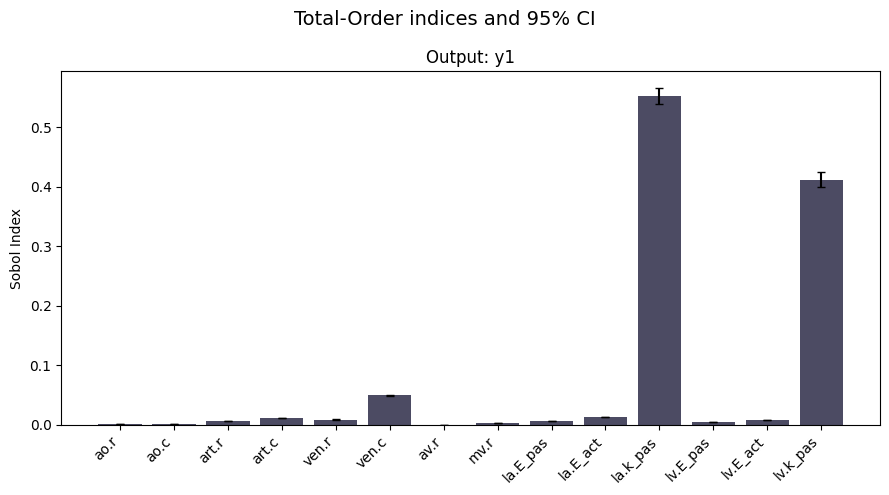

In [66]:
sa.plot_sobol(sobol_df, index="ST", figsize=figsize) 

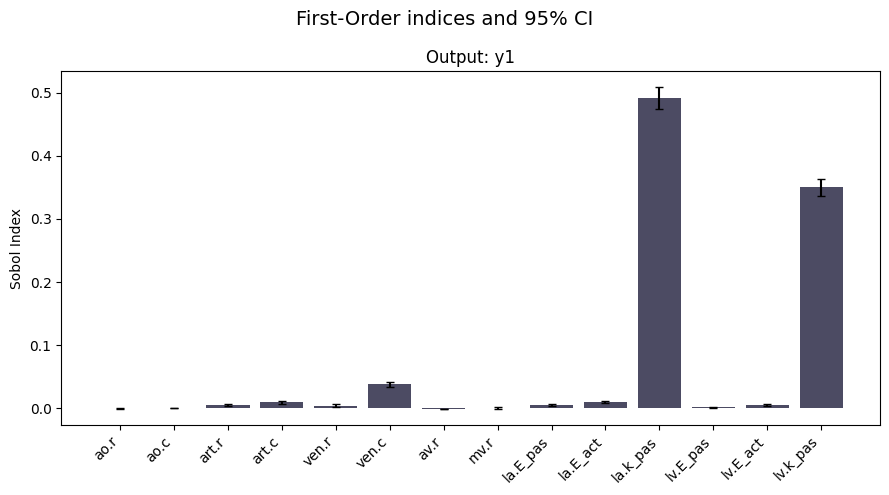

In [67]:
sa.plot_sobol(sobol_df, index="S1", figsize=figsize) 

In [68]:
# Create directories for saving plots if they don't exist
plots_dir = os.path.join(simulation_out_path, 'plots', f'{output_to_emulate}_{n_samples}_samples')
os.makedirs(plots_dir, exist_ok=True)

figsize = (9, 5)

# Plot and save S1
fig_S1 = SensitivityAnalysis.plot_sobol(sobol_df, index="S1", figsize=figsize)
if fig_S1 is None:
    # If the function does not return a fig, get the current figure instead
    fig_S1 = plt.gcf()
fig_S1.savefig(os.path.join(plots_dir, f'S1_{output_to_emulate}_{n_samples}_samples.png'), 
               dpi=300, bbox_inches='tight')
fig_S1.savefig(os.path.join(plots_dir, f'S1_{output_to_emulate}_{n_samples}_samples.pdf'), 
               bbox_inches='tight')
plt.close(fig_S1)  # Close the figure to free memory

print(f"S1 plot saved to: {plots_dir}")

# Plot and save ST
fig_ST = SensitivityAnalysis.plot_sobol(sobol_df, index="ST", figsize=figsize)
if fig_ST is None:
    fig_ST = plt.gcf()
fig_ST.savefig(os.path.join(plots_dir, f'ST_{output_to_emulate}_{n_samples}_samples.png'), 
               dpi=300, bbox_inches='tight')
fig_ST.savefig(os.path.join(plots_dir, f'ST_{output_to_emulate}_{n_samples}_samples.pdf'), 
               bbox_inches='tight')
plt.close(fig_ST)

print(f"ST plot saved to: {plots_dir}")

S1 plot saved to: ../outputs/simulations/output_2048_samples_parameters_naghavi_constrained_fixed_T_v_tot_v_ref_lower_k_pas/plots/p_la_max_2048_samples
ST plot saved to: ../outputs/simulations/output_2048_samples_parameters_naghavi_constrained_fixed_T_v_tot_v_ref_lower_k_pas/plots/p_la_max_2048_samples
